# Tutorial Completo: Análisis de Series de Tiempo

Simulación de ocupación de Camas UCI durante COVID-19 en Chile

## Sesión 1: Fundamentos y "Cómo Mirar" una Serie
### 0) Pregunta Clave: ¿Qué hace que un dato temporal sea distinto a uno tabular cualquiera?

La respuesta es que el orden importa. En una serie de tiempo, lo que pasó ayer afecta lo que sucede hoy. Los datos no son eventos aislados; son parte de una historia y tienen una memoria.

### 1) Creación de Datos Sintéticos Realistas

Comenzaremos creando un conjunto de datos sintéticos que simulan la ocupación de camas UCI, incluyendo una tendencia general, estacionalidad y las diferentes olas de la pandemia.

In [37]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("📊 TUTORIAL: ANÁLISIS DE SERIES DE TIEMPO")
print("=" * 50)

# Configuramos el período de análisis (marzo 2020 - diciembre 2022)
fecha_inicio = pd.Timestamp('2020-03-01')
fecha_fin = pd.Timestamp('2022-12-31')
fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
dias = np.arange(len(fechas))
np.random.seed(42)

# Simulamos datos realistas de ocupación UCI con múltiples componentes
ola1 = 300 * np.exp(-(dias - 60)**2 / 1000)
ola2 = 450 * np.exp(-(dias - 330)**2 / 1500)
ola3 = 380 * np.exp(-(dias - 480)**2 / 1200)
ola4 = 320 * np.exp(-(dias - 700)**2 / 1000)
ola5 = 250 * np.exp(-(dias - 850)**2 / 800)
tendencia_base = 150 + 50 * np.sin(dias / 365 * 2 * np.pi) + dias * 0.05
estacionalidad_semanal = 20 * np.sin(dias * 2 * np.pi / 7)
ruido = np.random.normal(0, 15, len(fechas))

ocupacion_uci = (tendencia_base + ola1 + ola2 + ola3 + ola4 + ola5 + estacionalidad_semanal + ruido)
ocupacion_uci = np.maximum(ocupacion_uci, 50)

df = pd.DataFrame({
    'fecha': fechas,
    'ocupacion_uci': ocupacion_uci.round(0).astype(int),
    'dia_semana': fechas.day_name(),
    'mes': fechas.month,
    'año': fechas.year
})

print(f"✅ Datos creados exitosamente: {len(df)} observaciones diarias")
print("\n📋 Primeras 5 observaciones:")
print(df.head())

📊 TUTORIAL: ANÁLISIS DE SERIES DE TIEMPO
✅ Datos creados exitosamente: 1036 observaciones diarias

📋 Primeras 5 observaciones:
       fecha  ocupacion_uci dia_semana  mes   año
0 2020-03-01            166     Sunday    3  2020
1 2020-03-02            174     Monday    3  2020
2 2020-03-03            191    Tuesday    3  2020
3 2020-03-04            196  Wednesday    3  2020
4 2020-03-05            154   Thursday    3  2020


### 2) Reorganización y Visualización Inicial
El primer paso para el análisis es preparar los datos. Esto significa que la columna de fecha debe ser el índice del DataFrame y que la serie debe estar ordenada cronológicamente. Luego, visualizamos la serie para identificar sus componentes a simple vista.

✅ Índice temporal establecido y ordenado.


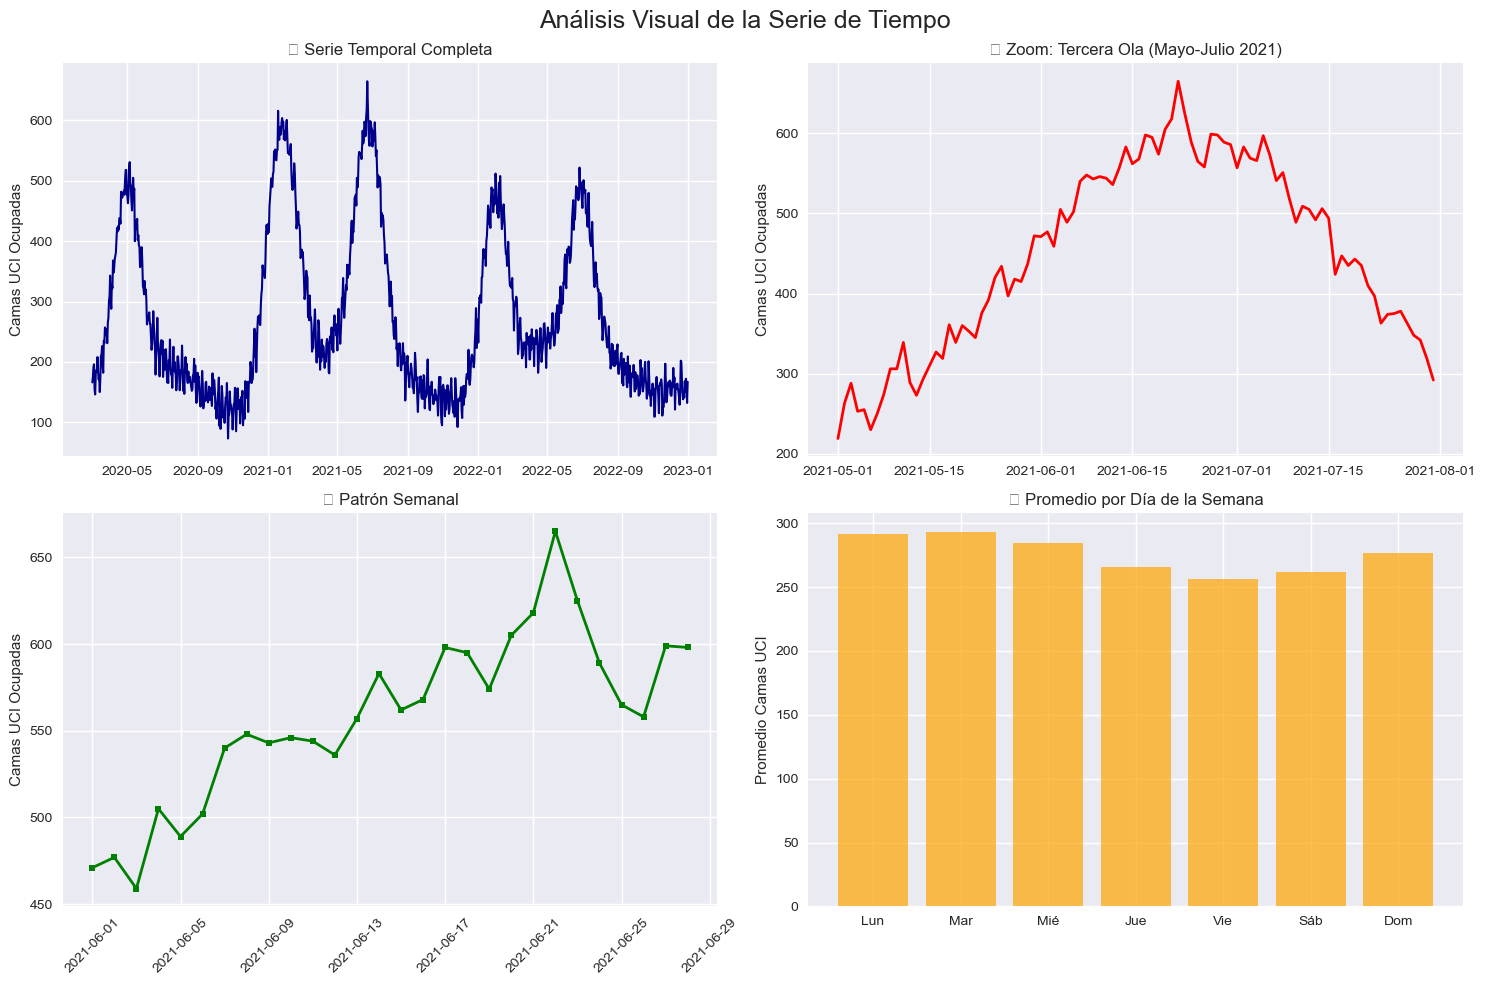

In [38]:
# Establecemos la fecha como índice
df_ts = df.set_index('fecha')
df_ts.sort_index(inplace=True)

print(f"✅ Índice temporal establecido y ordenado.")

# Gráfico principal de la serie
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis Visual de la Serie de Tiempo', fontsize=18)

# Gráfico 1: Serie completa
axes[0,0].plot(df_ts['ocupacion_uci'], linewidth=1.5, color='darkblue')
axes[0,0].set_title('📈 Serie Temporal Completa')
axes[0,0].set_ylabel('Camas UCI Ocupadas')

# Gráfico 2: Zoom en una ola específica
ola_ejemplo = df_ts.loc['2021-05':'2021-07']
axes[0,1].plot(ola_ejemplo['ocupacion_uci'], linewidth=2, color='red')
axes[0,1].set_title('🔍 Zoom: Tercera Ola (Mayo-Julio 2021)')
axes[0,1].set_ylabel('Camas UCI Ocupadas')

# Gráfico 3: Patrón semanal
cuatro_semanas = df_ts.loc['2021-06-01':'2021-06-28']
axes[1,0].plot(cuatro_semanas.index, cuatro_semanas['ocupacion_uci'], linewidth=2, color='green', marker='s', markersize=4)
axes[1,0].set_title('📅 Patrón Semanal')
axes[1,0].set_ylabel('Camas UCI Ocupadas')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Comparación por día de la semana
ocupacion_por_dia = df.groupby('dia_semana')['ocupacion_uci'].mean()
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ocupacion_por_dia = ocupacion_por_dia.reindex(orden_dias)

axes[1,1].bar(range(7), ocupacion_por_dia.values, color='orange', alpha=0.7)
axes[1,1].set_title('📊 Promedio por Día de la Semana')
axes[1,1].set_ylabel('Promedio Camas UCI')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])

plt.tight_layout()
plt.show()

### 3) Los 3 Componentes Clave de una Serie de Tiempo
Casi cualquier serie de tiempo puede descomponerse en tres componentes fundamentales:

* Tendencia (Trend): El movimiento a largo plazo de la serie. Puede ser ascendente, descendente o plano. En nuestro caso, la ocupación de camas UCI tiene varias tendencias ascendentes y descendentes (las "olas" de la pandemia).

* Estacionalidad (Seasonality): Son patrones que se repiten en intervalos de tiempo fijos y conocidos, como por semana, mes o año. En nuestro ejemplo, la ocupación de camas podría ser un poco más alta los lunes y más baja los fines de semana.

* Errores o Residuos (Residuals): Lo que queda después de remover la tendencia y la estacionalidad. Es la parte aleatoria, impredecible de la serie. Un buen modelo debería dejar como resultado solo estos "residuos".

La estacionariedad se relaciona directamente con esto. Una serie es estacionaria cuando se han eliminado la tendencia y la estacionalidad, dejando solo la parte aleatoria. Los modelos como ARIMA se desempeñan mejor con series estacionarias.

### 4) Descomposición Formal de la Serie de Tiempo
Podemos usar la función seasonal_decompose para separar formalmente estos tres componentes. Esto nos da una visión clara de cada uno de ellos.

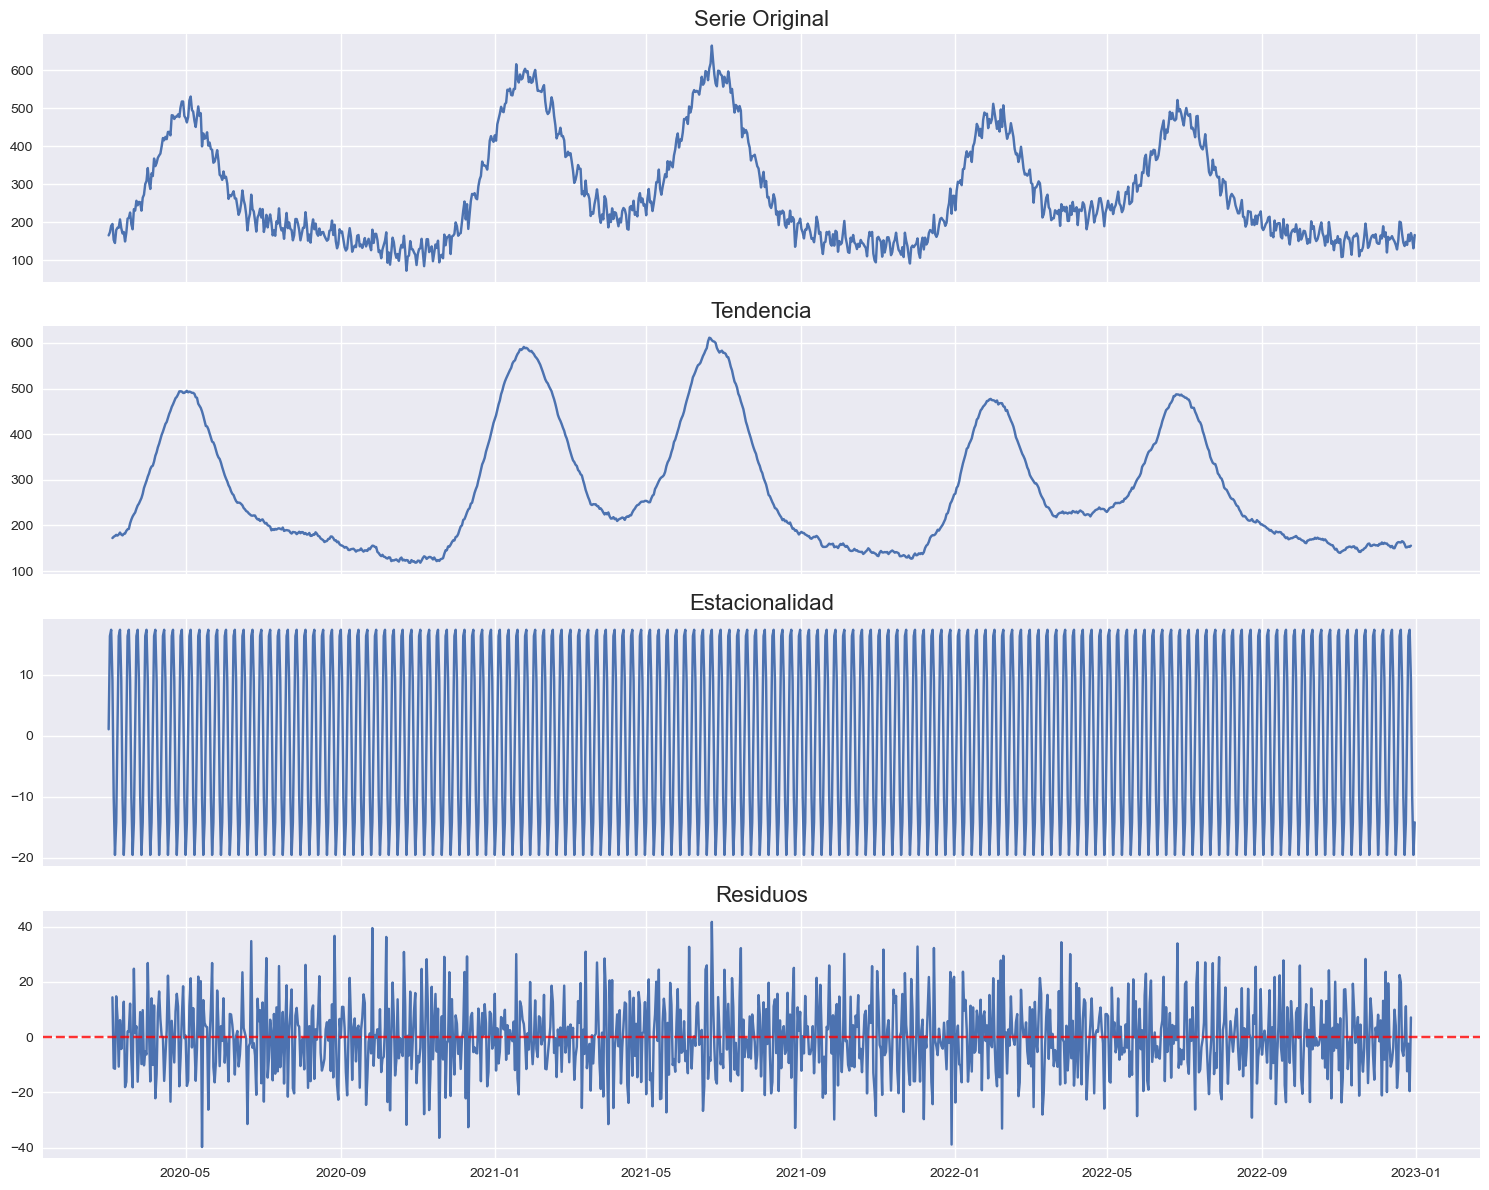

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realizamos la descomposición. Usamos el modelo 'additive' ya que la magnitud de la estacionalidad no crece con la tendencia.
descomposicion = seasonal_decompose(df_ts['ocupacion_uci'], model='additive', period=7)

# Graficamos los componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Serie original
ax1.plot(descomposicion.observed)
ax1.set_title('Serie Original', fontsize=16)

# Tendencia
ax2.plot(descomposicion.trend)
ax2.set_title('Tendencia', fontsize=16)

# Estacionalidad
ax3.plot(descomposicion.seasonal)
ax3.set_title('Estacionalidad', fontsize=16)

# Residuos
ax4.plot(descomposicion.resid)
ax4.set_title('Residuos', fontsize=16)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.show()

### 4) Estacionariedad: Un Concepto Clave

Una serie es estacionaria si sus propiedades estadísticas (media y varianza) no cambian con el tiempo. La mayoría de los modelos clásicos como ARIMA lo necesitan. Si el gráfico de la serie 'se arrastra' hacia arriba o abajo, no es estacionaria.

Una técnica para lograr la estacionariedad es la diferenciación, que es simplemente calcular la diferencia entre un punto y el anterior. Esto elimina la tendencia.

**Test de Dickey-Fuller (Serie Original)**
P-valor: 0.0000
Conclusión: La serie es estacionaria

**Test de Dickey-Fuller (Serie Diferenciada)**
P-valor: 0.0011
Conclusión: La serie es estacionaria


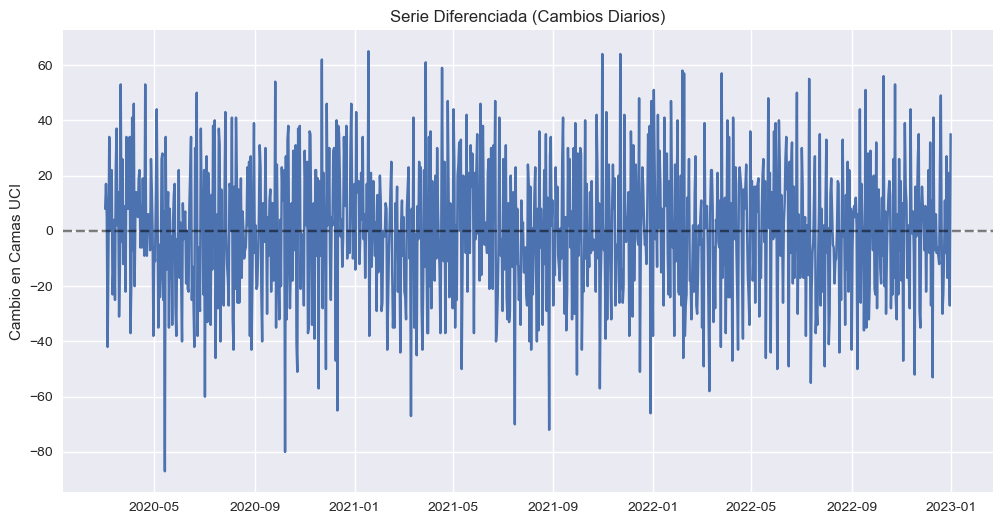

In [40]:
from statsmodels.tsa.stattools import adfuller

# Calculamos la primera diferencia
df_ts['cambio_diario'] = df_ts['ocupacion_uci'].diff().dropna()

# Test de Dickey-Fuller Aumentado (ADF) en la serie original
result_original = adfuller(df_ts['ocupacion_uci'])
print('**Test de Dickey-Fuller (Serie Original)**')
print(f'P-valor: {result_original[1]:.4f}')
print('Conclusión: La serie NO es estacionaria' if result_original[1] >= 0.05 else 'Conclusión: La serie es estacionaria')

# Test de Dickey-Fuller Aumentado (ADF) en la serie diferenciada
# Para evitar errores, aseguramos que la serie no tenga valores faltantes
serie_diff_limpia = df_ts['cambio_diario'].dropna()
result_diff = adfuller(serie_diff_limpia)
print('\n**Test de Dickey-Fuller (Serie Diferenciada)**')
print(f'P-valor: {result_diff[1]:.4f}')
print('Conclusión: La serie es estacionaria' if result_diff[1] < 0.05 else 'Conclusión: La serie NO es estacionaria')

plt.figure(figsize=(12, 6))
plt.plot(df_ts['cambio_diario'])
plt.title('Serie Diferenciada (Cambios Diarios)')
plt.ylabel('Cambio en Camas UCI')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.show()

#### Explicación

* .diff(): Este es el método clave. Calcula la diferencia entre cada observación y la anterior. Por ejemplo, el valor del día 2 se convierte en (valor del día 2 - valor del día 1). El objetivo de esto es eliminar la tendencia, convirtiendo una serie que "se arrastra" hacia arriba o hacia abajo en una que oscila alrededor de un valor constante (idealmente, cero).

* .dropna(): Cuando calculas la diferencia, la primera observación no tiene un valor anterior con el cual compararse, por lo que se crea un valor NaN (no es un número). Este método simplemente elimina esa primera fila, asegurando que no haya datos faltantes que puedan causar un error en los siguientes pasos.

* El Test de Dickey-Fuller Aumentado (ADF)
La función adfuller() es la prueba estadística que determina si la serie es estacionaria.

**Hipótesis Nula (H_0):** La serie de tiempo no es estacionaria.

**Hipótesis Alternativa (H_a):** La serie de tiempo es estacionaria.

El resultado clave de esta prueba es el valor p.

**Si el valor p es bajo (menor a 0.05):** Rechazamos la hipótesis nula y concluimos que la serie es estacionaria.

**Si el valor p es alto (mayor o igual a 0.05):** No podemos rechazar la hipótesis nula y concluimos que la serie no es estacionaria.

El código ejecuta esta prueba en dos series para demostrar el efecto de la diferenciación:

**result_original = adfuller(df_ts['ocupacion_uci']):** Se realiza la prueba en la serie original. Como la serie tiene una tendencia clara, el valor p será alto, confirmando que no es estacionaria.

**result_diff = adfuller(serie_diff_limpia):** Se realiza la prueba en la serie que acabamos de diferenciar. Si la diferenciación funcionó, el valor p debería ser bajo, confirmando que ahora la serie sí es estacionaria.

### 4) Autocorrelación: La Memoria de la Serie

La autocorrelación mide cuánto se parece una serie a sí misma en el pasado. Un gráfico de ACF te muestra esta relación en diferentes desfases de tiempo (o lags). Una barra alta en el lag 7, por ejemplo, sugiere una estacionalidad semanal.

### 1. Gráfico de la Serie Original (Serie Original: Niveles)
Este primer gráfico de la serie ocupacion_uci te dice mucho:

Las barras altas que descienden lentamente: Esto es la señal más clara de una serie no estacionaria. Las barras no caen rápidamente al área sombreada (el umbral de significancia) porque cada valor está fuertemente correlacionado con los valores que le precedieron, lo que confirma que hay una tendencia en tus datos.

La correlación alta en el lag 7: Probablemente veas una barra significativa en el lag 7 y sus múltiplos (14, 21, etc.). Esta es la evidencia visual de la estacionalidad semanal que ya habíamos notado. La ocupación de camas de un día se parece mucho a la de hace exactamente una semana.

En resumen, este gráfico confirma visualmente lo que ya sabíamos: la serie original no es estacionaria debido a su tendencia y estacionalidad.

### 2. Gráfico de la Serie Diferenciada (Primera Diferencia: Cambios)
Este segundo gráfico te muestra cómo la diferenciación transformó tu serie:

**La caída rápida:** Al calcular la diferencia, eliminaste la tendencia. Por eso, las barras caen inmediatamente a cero y se mantienen dentro del área sombreada. Esto te dice que la serie es ahora estacionaria, ya que no existe una correlación a largo plazo.

**El pico en el lag 7:** El lag 7 probablemente sigue mostrando una pequeña, pero significativa, correlación. Esto significa que la estacionalidad semanal no ha sido eliminada por completo con la primera diferenciación. Para un modelo más preciso, podrías considerar una diferenciación estacional, que es un concepto más avanzado.

En resumen, la diferenciación hizo su trabajo al estabilizar la media de la serie, un paso crucial para modelos como ARIMA. La presencia de un pico en el lag 7 en el gráfico de la serie diferenciada indica que todavía hay un patrón estacional que podría ser capturado.

Serie Original vs. Serie Diferenciada
La principal diferencia es la presencia de la tendencia.

**La Serie Original:** Muestra el valor absoluto de la ocupación de camas a lo largo del tiempo. Su característica principal es que es no estacionaria, lo que significa que su media y varianza cambian con el tiempo. El gráfico de esta serie tiene grandes movimientos hacia arriba y abajo (las "olas" de la pandemia), que es lo que llamamos tendencia. Los valores de hoy están directamente relacionados con los valores de ayer, y esa correlación se mantiene a lo largo del tiempo.

**La Serie Diferenciada:** En el código que seleccionaste, esta serie es el resultado de restar el valor de ocupación de camas del día anterior al valor del día de hoy. El objetivo de este proceso es eliminar la tendencia. El resultado es una serie que ya no tiene una dirección clara y que oscila alrededor de un valor constante (idealmente, cero). Esta serie es estacionaria, lo que la hace adecuada para muchos modelos de pronóstico como ARIMA, que requieren que los datos no tengan una tendencia.

En resumen, la serie original te muestra el panorama general con sus tendencias y estacionalidades, mientras que la serie diferenciada te muestra solo los cambios diarios o incrementos, revelando la parte aleatoria de los datos y haciendo que la serie sea estacionaria para un mejor análisis.

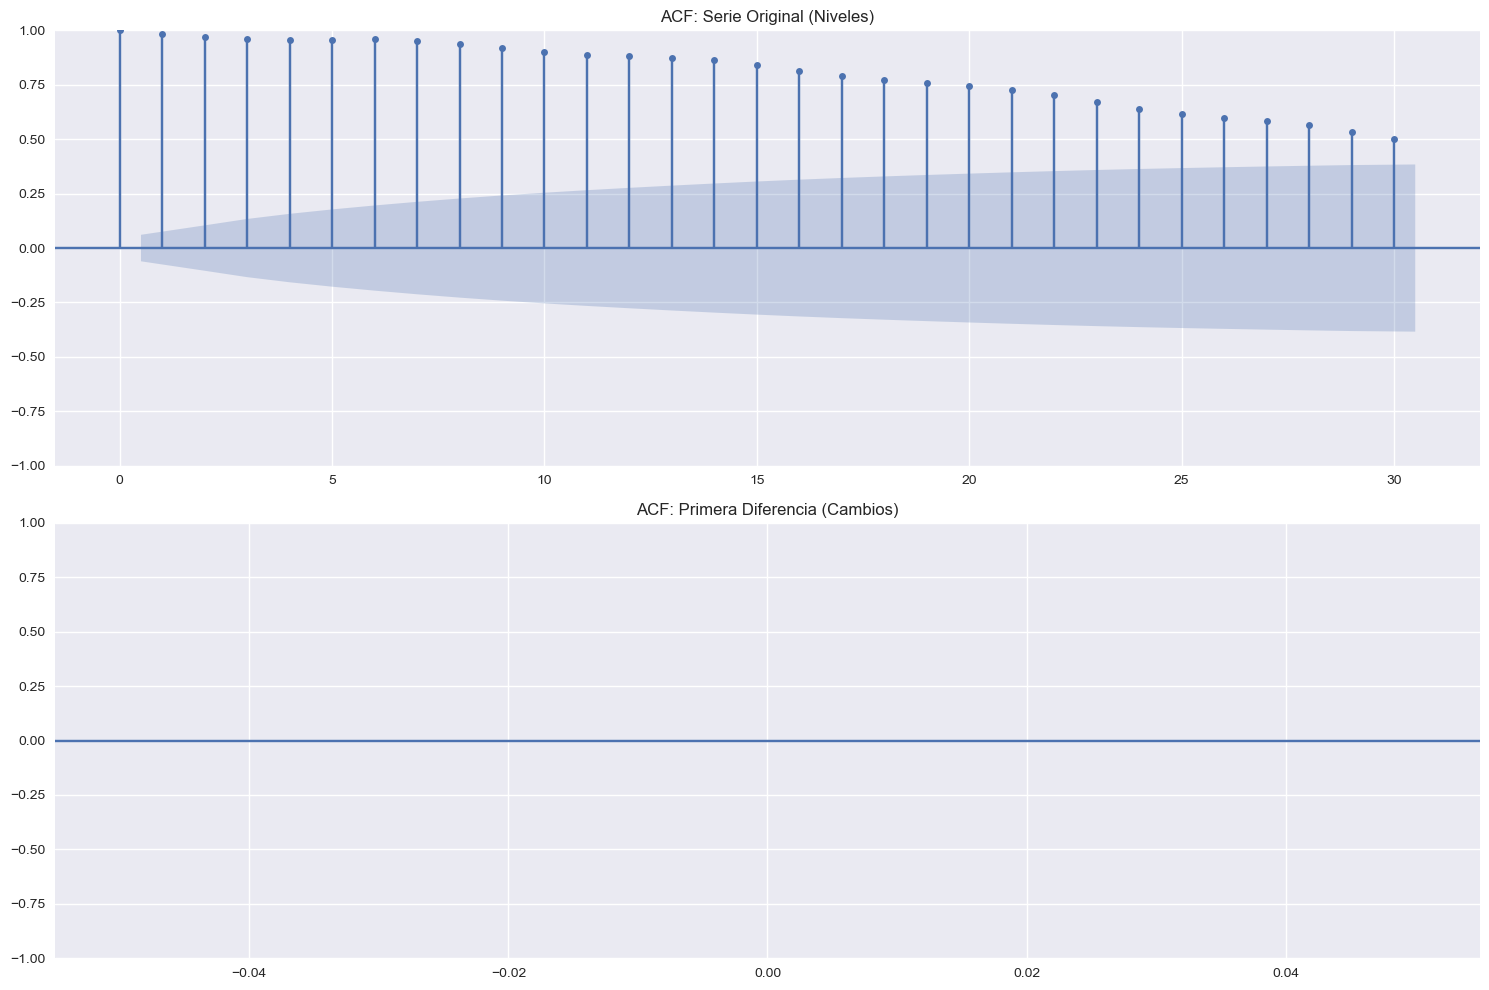

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# ACF para la serie original
plot_acf(df_ts['ocupacion_uci'], ax=ax1, lags=30)
ax1.set_title('ACF: Serie Original (Niveles)')

# ACF para la serie diferenciada
plot_acf(df_ts['cambio_diario'], ax=ax2, lags=30)
ax2.set_title('ACF: Primera Diferencia (Cambios)')

plt.tight_layout()
plt.show()

## Sesión 2: Modelos, Límites de la Regresión y Forecasting
5) División de Datos: Entrenamiento y Prueba
La regla de oro para series de tiempo es validar mirando hacia adelante. Esto significa que solo usas datos del pasado para predecir el futuro. Dividiremos la serie en un 80% para entrenar y un 20% para probar.

División de datos:
• Entrenamiento: 2020-03-01 a 2022-06-06 (828 días)
• Prueba: 2022-06-07 a 2022-12-31 (208 días)


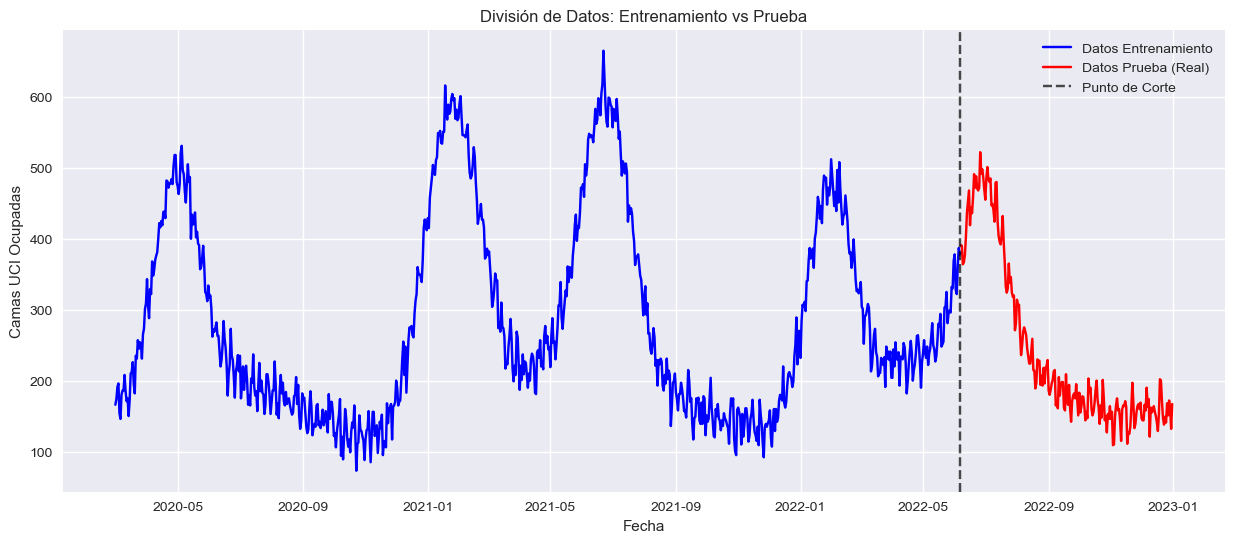

In [42]:
# Dividimos los datos
punto_corte = int(len(df_ts) * 0.8)
train = df_ts.iloc[:punto_corte].copy()
test = df_ts.iloc[punto_corte:].copy()

print(f"División de datos:")
print(f"• Entrenamiento: {train.index[0].date()} a {train.index[-1].date()} ({len(train)} días)")
print(f"• Prueba: {test.index[0].date()} a {test.index[-1].date()} ({len(test)} días)")

# Visualizamos la división
plt.figure(figsize=(15, 6))
plt.plot(train['ocupacion_uci'], label='Datos Entrenamiento', color='blue')
plt.plot(test['ocupacion_uci'], label='Datos Prueba (Real)', color='red')
plt.axvline(x=train.index[-1], color='black', linestyle='--', alpha=0.7, label='Punto de Corte')
plt.title('División de Datos: Entrenamiento vs Prueba')
plt.xlabel('Fecha')
plt.ylabel('Camas UCI Ocupadas')
plt.legend()
plt.show()

### 6) Comparación de Modelos de Forecasting
Probaremos tres modelos para predecir los datos de prueba y compararemos su rendimiento usando el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE). Siempre es bueno tener un modelo de referencia (Naïve) para ver si tus modelos complejos realmente están aportando algo.

#### Interpretación del Código: Comparación de Modelos
El propósito de este código es comparar el rendimiento de tres modelos de pronóstico diferentes, utilizando el Error Absoluto Medio (MAE) como métrica principal. Un MAE más bajo significa que el modelo es, en promedio, más preciso en sus predicciones.

**Modelo Naïve (Ingenuo):**

Este es el modelo más simple y sirve como línea de base. Su lógica es: "el valor de mañana será el mismo que el de hoy". Es ingenuo, pero es un punto de referencia crucial. Si un modelo más complejo no puede superar al modelo Naïve, no vale la pena usarlo.

**Modelo ARIMA(1,1,1):**

ARIMA es un modelo más avanzado que utiliza la "memoria" de la serie para predecir. Sus tres parámetros son clave:

* AR (1): Utiliza el valor del día anterior para la predicción.

* I (1): Indica que se usó una diferenciación para que la serie fuera estacionaria (como vimos en el paso anterior).

* MA (1): Utiliza el error de la predicción del día anterior para corregir el pronóstico actual.

El código intenta ajustar este modelo y hace una predicción. El bloque try...except es una buena práctica de programación que permite que el código continúe ejecutándose incluso si el modelo ARIMA no puede ajustarse por alguna razón, usando en su lugar el modelo Naïve.

**Modelo de Media Móvil:**

Este modelo toma el promedio de un número específico de días anteriores (en este caso, 7 días) para hacer su pronóstico. Es una técnica de suavizado que funciona bien cuando los datos tienen variaciones aleatorias.

El código finaliza creando una tabla DataFrame que resume el MAE de cada modelo. Esto te permite ver de manera sencilla y cuantitativa cuál modelo tuvo el mejor rendimiento en el período de prueba.

In [43]:
# 1. Modelo Naïve (ingenuo): "mañana = hoy"
ultimo_valor_train = train['ocupacion_uci'].iloc[-1]
predicciones_naive = pd.Series([ultimo_valor_train] * len(test), index=test.index)
mae_naive = mean_absolute_error(test['ocupacion_uci'], predicciones_naive)

print(f"**Resultados Modelo Naïve**")
print(f"- MAE: {mae_naive:.1f} camas")

# 2. Modelo ARIMA(1,1,1)
try:
    modelo_arima = ARIMA(train['ocupacion_uci'], order=(1,1,1))
    modelo_ajustado = modelo_arima.fit()
    predicciones_arima = modelo_ajustado.forecast(steps=len(test))
    mae_arima = mean_absolute_error(test['ocupacion_uci'], predicciones_arima)
except Exception as e:
    print("\n❌ Error en ARIMA, se usa modelo Naïve como respaldo.")
    predicciones_arima = predicciones_naive
    mae_arima = mae_naive

print(f"\n**Resultados Modelo ARIMA(1,1,1)**")
print(f"- MAE: {mae_arima:.1f} camas")

# 3. Modelo de Media Móvil
ventana_ma = 7
media_movil_train = train['ocupacion_uci'].rolling(window=ventana_ma).mean()
ultimo_promedio = media_movil_train.iloc[-1]
predicciones_ma = pd.Series([ultimo_promedio] * len(test), index=test.index)
mae_ma = mean_absolute_error(test['ocupacion_uci'], predicciones_ma)

print(f"\n**Resultados Modelo Media Móvil ({ventana_ma} días)**")
print(f"- MAE: {mae_ma:.1f} camas")

# Tabla de resultados
resultados = pd.DataFrame({
    'Modelo': ['Naïve', 'ARIMA(1,1,1)', f'Media Móvil ({ventana_ma}d)'],
    'MAE': [mae_naive, mae_arima, mae_ma]
})

print("\n**Resumen de Comparación**")
print(resultados.set_index('Modelo').round(1))

**Resultados Modelo Naïve**
- MAE: 164.1 camas

**Resultados Modelo ARIMA(1,1,1)**
- MAE: 160.4 camas

**Resultados Modelo Media Móvil (7 días)**
- MAE: 153.8 camas

**Resumen de Comparación**
                    MAE
Modelo                 
Naïve             164.1
ARIMA(1,1,1)      160.4
Media Móvil (7d)  153.8


### 7) Visualización de las Predicciones
Finalmente, graficaremos las predicciones de cada modelo para ver visualmente cómo se comparan con los datos reales en el período de prueba. 

#### Interpretación del Gráfico Resultante
El gráfico final es la representación visual de la tabla de resultados. Es la forma más intuitiva de entender cómo se comportó cada modelo.

**Línea azul (Datos de Entrenamiento):** La parte de la serie que los modelos "vieron" para aprender el patrón.

**Línea roja (Datos Prueba - Real):** El futuro que los modelos no vieron. Esta es la verdad, el resultado real que ocurrió en el mundo.

**Líneas de predicción (gris, verde, morada):** Las predicciones de cada modelo en el período de prueba.

Para interpretar el gráfico, simplemente mira qué línea de predicción se acerca más a la línea roja durante el período de prueba. El modelo cuya línea de predicción es más cercana a la línea real es el que tuvo el mejor desempeño.

En resumen, el código calcula los resultados y la tabla los cuantifica, pero el gráfico te da una comprensión visual inmediata de cuál modelo es el mejor.


#### Predicción Constante vs. Predicción Dinámica

La diferencia fundamental entre los modelos está en cómo calculan cada punto de la predicción.

**Modelos Naïve y Media Móvil:** Estos modelos no tienen "memoria" del futuro. Simplemente toman un valor fijo del pasado y lo usan como la predicción para todos los días futuros.

* El modelo Naïve usa el último valor conocido.

* El modelo de Media Móvil usa el último promedio.

* El resultado es una predicción completamente constante y sin cambios, por eso ves líneas perfectamente horizontales.

**Modelo ARIMA:** Este modelo es diferente. Sus parámetros le permiten aprender de la tendencia de la serie. Aunque la predicción se inicia desde el último valor del conjunto de entrenamiento, el modelo ajusta ligeramente esa predicción con cada paso de tiempo, siguiendo la dirección general de la serie.

Para ilustrarlo, imagina que la predicción para el primer día es 200.

Los modelos Naïve y de Media Móvil predirán: 200, 200, 200, 200...

El modelo ARIMA, al notar que la tendencia es descendente, predirá algo como: 200, 199.5, 199, 198.5...

Aunque el cambio es minúsculo en cada día, la dirección de la predicción es correcta y acumulativa. Por eso decimos que "captura la tendencia", porque su predicción se mueve en la misma dirección que los datos reales, a diferencia de las otras que se quedan estancadas.

!Cómo ver la diferencia tú mismo!
Para convencerte, podemos imprimir los primeros 5 valores de cada predicción. Si ejecutas el siguiente código en tu Canvas, verás claramente la diferencia numérica:

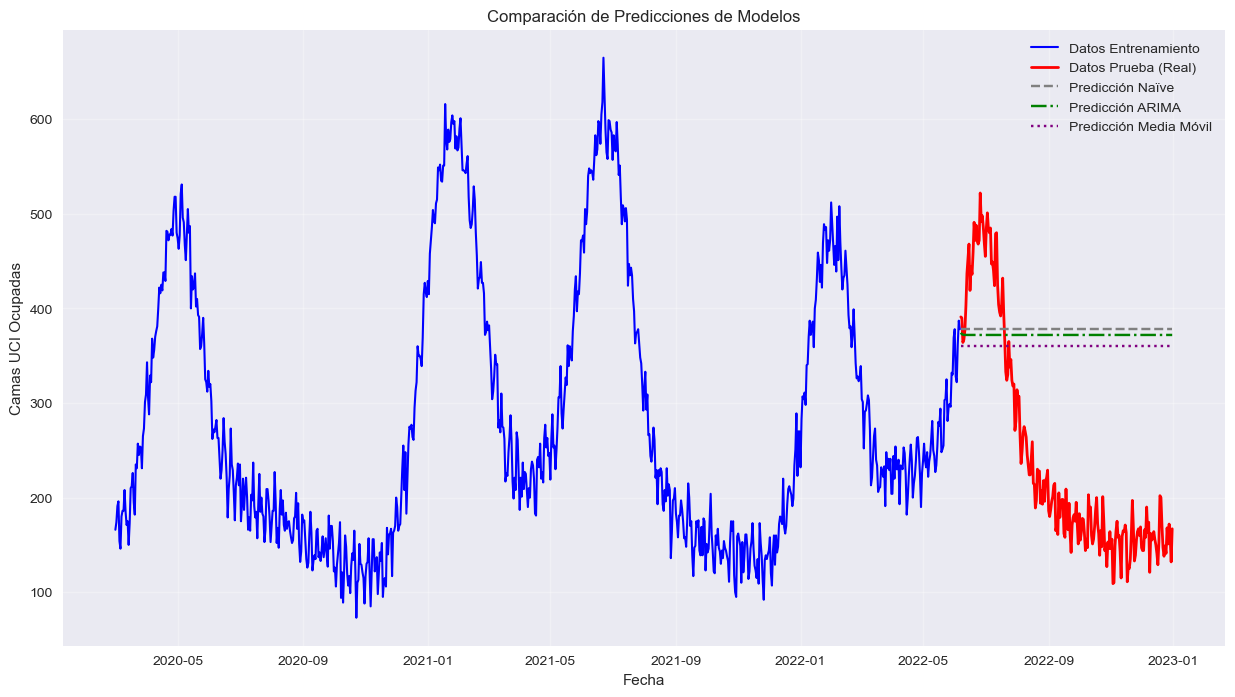

Predicciones Naïve: [378 378 378 378 378]
Predicciones Media Móvil: [360.57142857 360.57142857 360.57142857 360.57142857 360.57142857]
Predicciones ARIMA: [374.2 372.8 372.3 372.1 372. ]


In [44]:
plt.figure(figsize=(15, 8))

# Datos de entrenamiento y prueba
plt.plot(train['ocupacion_uci'], label='Datos Entrenamiento', color='blue', linewidth=1.5)
plt.plot(test['ocupacion_uci'], label='Datos Prueba (Real)', color='red', linewidth=2)

# Predicciones de los modelos
plt.plot(predicciones_naive, label='Predicción Naïve', color='gray', linestyle='--')
plt.plot(predicciones_arima, label='Predicción ARIMA', color='green', linestyle='-.')
plt.plot(predicciones_ma, label='Predicción Media Móvil', color='purple', linestyle=':')

plt.title('Comparación de Predicciones de Modelos')
plt.xlabel('Fecha')
plt.ylabel('Camas UCI Ocupadas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


print("Predicciones Naïve:", predicciones_naive.head(5).values)
print("Predicciones Media Móvil:", predicciones_ma.head(5).values)
print("Predicciones ARIMA:", predicciones_arima.head(5).values.round(1))


### 8) Checklist de Buenas Prácticas y Próximos Pasos
Dibuja antes de modelar: La visualización inicial es clave.

Valida hacia adelante: Siempre usa datos futuros para probar tu modelo.

Compite contra un Naïve: Si tu modelo complejo no supera a un modelo ingenuo, no está funcionando.

Revisa los residuos: Los errores de tu modelo deberían parecer ruido aleatorio (sin patrón).

Entrega intervalos de confianza: Un pronóstico sin un rango de incertidumbre no es completo.